In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import muon as mu
# import anndata2ri
import logging
# import scvi
import os
import scipy
import scipy.io
import scib
# import rpy2.rinterface_lib.callbacks
import seaborn as sns
import matplotlib.pyplot as plt

# from rpy2.robjects import r
# from rpy2.robjects import pandas2ri

# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

import warnings

warnings.filterwarnings("ignore")

In [7]:
rna = sc.read("/home/xcx/MYBenchmark-codes/11-MultiVI/mydata/P0/rna.h5ad", cache=True)
print(rna)
atac = sc.read("/home/xcx/MYBenchmark-codes/11-MultiVI/mydata/P0/atac.h5ad", cache=True)
print(atac)

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'gene_id', 'modality'
AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'region_id', 'modality'


In [9]:
mdata = mu.MuData({"rna": rna, "atac": atac})
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 5081 × 248751
  var:	'modality'
  2 modalities
    rna:	5081 x 19322
      obs:	'barcode', 'cell_type', 'batch', 'modality'
      var:	'gene_id', 'modality'
    atac:	5081 x 229429
      obs:	'barcode', 'cell_type', 'batch', 'modality'
      var:	'region_id', 'modality'

In [ ]:
# RNA preprossing
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'gene_id', 'modality'

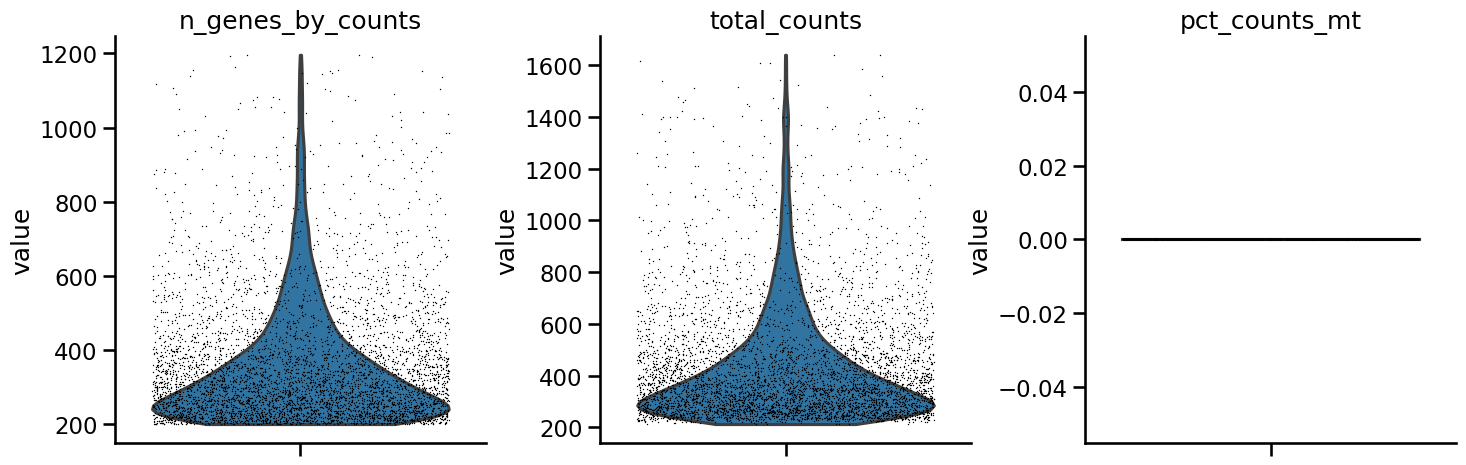

In [11]:
# QC
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

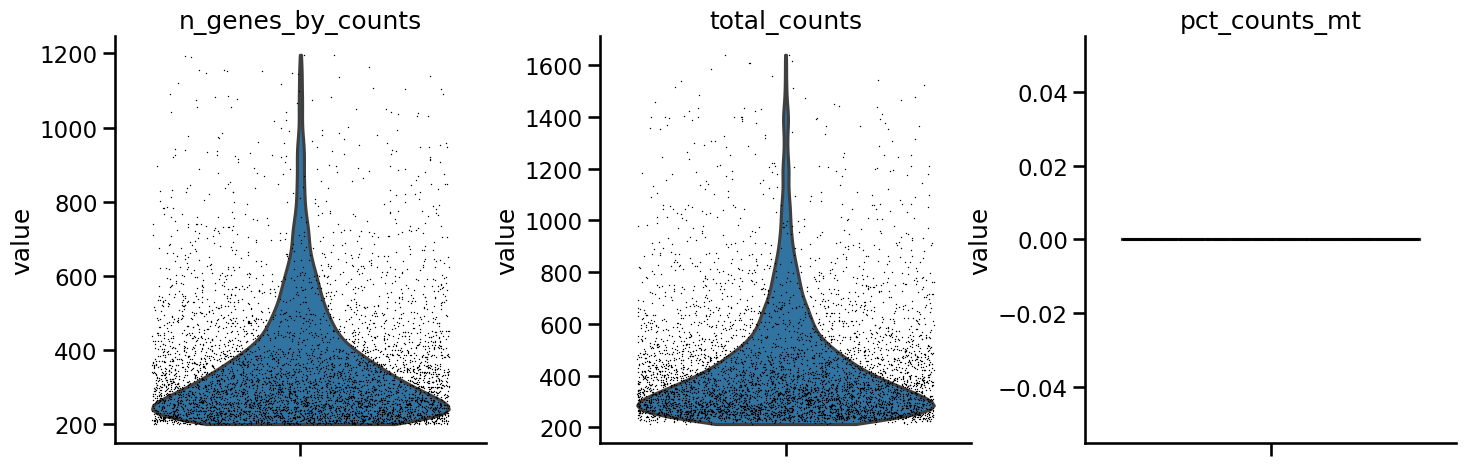

In [12]:
# filter genes
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)

# filter cells
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

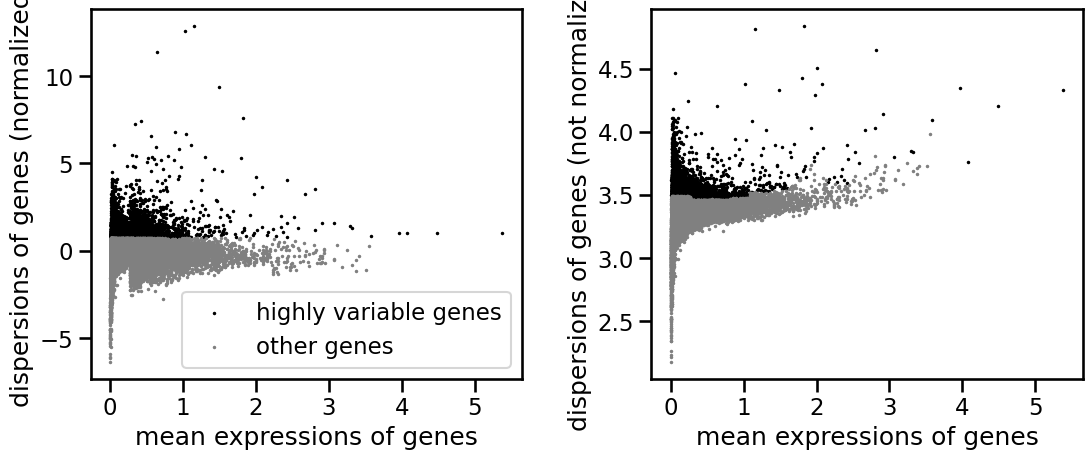

In [13]:
# normalise
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# feature select
sc.pp.highly_variable_genes(rna, n_top_genes=2500)
sc.pl.highly_variable_genes(rna)

In [ ]:
rna=rna[:,rna.var.highly_variable]
rna

View of AnnData object with n_obs × n_vars = 5081 × 2500
    obs: 'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'modality', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [15]:
# save log-normalised in .raw
rna.raw = rna
# scale the log-normalised counts to zero mean and unit variance
sc.pp.scale(rna, max_value=10)

In [16]:
# ATAC preprossing
atac = mdata.mod['atac']
atac

AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'barcode', 'cell_type', 'batch', 'modality'
    var: 'region_id', 'modality'

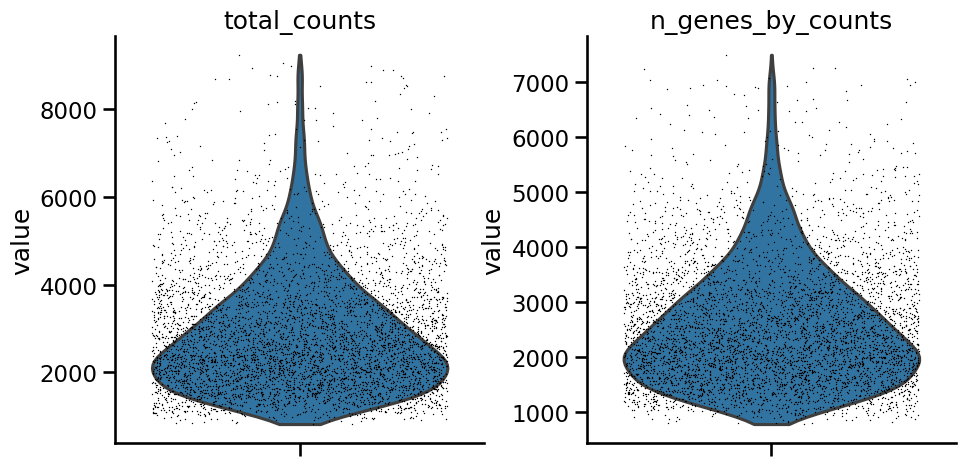

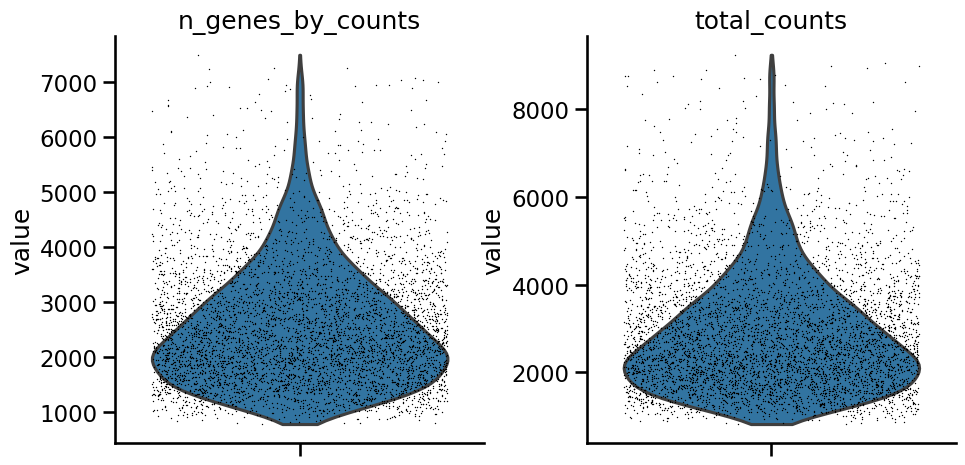

In [17]:
# QC
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)
# for peaks
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# for cells
# mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [18]:
# normalisation
# Save original counts
from muon import atac as ac
atac.layers["counts"] = atac.X
ac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

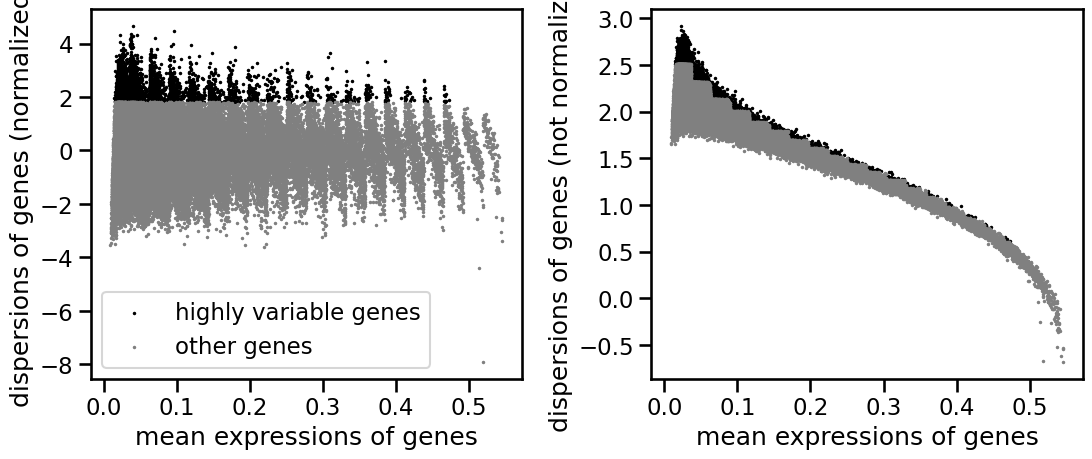

View of AnnData object with n_obs × n_vars = 5081 × 5000
    obs: 'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [19]:
# feature selection
sc.pp.highly_variable_genes(atac, n_top_genes=5000)
sc.pl.highly_variable_genes(atac)
atac=atac[:,atac.var.highly_variable]
atac

In [20]:
atac.raw = atac
atac

AnnData object with n_obs × n_vars = 5081 × 5000
    obs: 'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [21]:
# save data after preprossing
mdata = mu.MuData({"rna": rna, "atac": atac})
mdata.write("/home/xcx/MYBenchmark-codes/10-MOFA+/data/P0/P0.h5mu")

In [22]:
mdata = mu.read("/home/xcx/MYBenchmark-codes/10-MOFA+/data/P0/P0.h5mu")
mdata

MuData object with n_obs × n_vars = 5081 × 7500
  var:	'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	5081 x 2500
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_id', 'modality', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'log1p'
    atac:	5081 x 5000
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
      layers:	'counts'

In [23]:
mu.pp.intersect_obs(mdata)
mdata.shape

(5081, 7500)

In [24]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:cell_type'], mdata.obs['atac:cell_type'])

1.0

<Axes: xlabel='rna:cell_type', ylabel='atac:cell_type'>

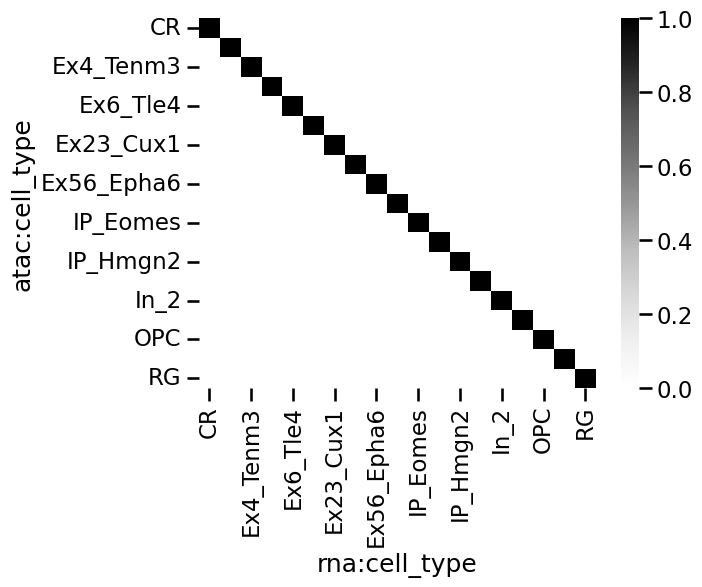

In [25]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:cell_type").
        size().
        reset_index(name="n_total").
        set_index("atac:cell_type")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:cell_type", "rna:cell_type"]).
        size().
        reset_index(name="n").
        set_index("atac:cell_type").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)
df_wide = df_frac.set_index("atac:cell_type").pivot(columns="rna:cell_type", values="frac")
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")

In [26]:
mdata.obs["batch"] = mdata["rna"].obs["batch"].copy()
mdata.obs["cell_type"] = mdata["rna"].obs["cell_type"].copy()
mdata.obs

,rna:barcode,rna:cell_type,rna:batch,rna:modality,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,atac:barcode,atac:cell_type,atac:batch,atac:modality,atac:n_genes_by_counts,atac:total_counts,atac:n_counts,batch,cell_type
AAAACCGGAAGC,AAAACCGGAAGC,Ex6_Tle4,1.0,scRNA-seq,286,349.0,0.0,0.0,AAAACCGGAAGC,Ex6_Tle4,1.0,scATAC-seq,1233,1316.0,7019.466309,1.0,Ex6_Tle4
AAAACTCTGACG,AAAACTCTGACG,Ex56_Epha6,1.0,scRNA-seq,229,268.0,0.0,0.0,AAAACTCTGACG,Ex56_Epha6,1.0,scATAC-seq,1604,1711.0,8725.654297,1.0,Ex56_Epha6
AAAAGACCTGCG,AAAAGACCTGCG,Ex5_Crmp1,1.0,scRNA-seq,306,349.0,0.0,0.0,AAAAGACCTGCG,Ex5_Crmp1,1.0,scATAC-seq,2020,2241.0,9602.619141,1.0,Ex5_Crmp1
AAAAGAGATATG,AAAAGAGATATG,Ex345_Foxp1,1.0,scRNA-seq,568,743.0,0.0,0.0,AAAAGAGATATG,Ex345_Foxp1,1.0,scATAC-seq,3375,3808.0,13184.691406,1.0,Ex345_Foxp1
AAAAGAGATGGA,AAAAGAGATGGA,Ex6_Tle4,1.0,scRNA-seq,285,339.0,0.0,0.0,AAAAGAGATGGA,Ex6_Tle4,1.0,scATAC-seq,1549,1651.0,8517.594727,1.0,Ex6_Tle4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTGGTTTTG,TTTTTGGTTTTG,Ex345_Foxp1,1.0,scRNA-seq,278,370.0,0.0,0.0,TTTTTGGTTTTG,Ex345_Foxp1,1.0,scATAC-seq,2484,2774.0,11007.315430,1.0,Ex345_Foxp1
TTTTTGTACAAA,TTTTTGTACAAA,IP_Eomes,1.0,scRNA-seq,275,337.0,0.0,0.0,TTTTTGTACAAA,IP_Eomes,1.0,scATAC-seq,1525,1627.0,8337.123047,1.0,IP_Eomes
TTTTTTACCGAG,TTTTTTACCGAG,Ex345_Foxp1,1.0,scRNA-seq,425,567.0,0.0,0.0,TTTTTTACCGAG,Ex345_Foxp1,1.0,scATAC-seq,2734,3040.0,11635.467773,1.0,Ex345_Foxp1
TTTTTTGCAATT,TTTTTTGCAATT,OPC,1.0,scRNA-seq,770,1013.0,0.0,0.0,TTTTTTGCAATT,OPC,1.0,scATAC-seq,6177,7539.0,16781.728516,1.0,OPC


In [28]:
import datetime
starttime = datetime.datetime.now()

mu.tl.mofa(mdata, gpu_mode=True, outfile="/home/xcx/results/P0/10-MOFA+/new_snare_rna_atac.hdf5")

#long running
endtime = datetime.datetime.now()
print((endtime-starttime).seconds)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=5081 samples and D=2500 features...
Loaded view='atac' group='group1' with N=5081 samples and D=5000 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: T

In [29]:
print(mdata)
mdata.obsm['X_mofa'].shape

MuData object with n_obs × n_vars = 5081 × 7500
  obs:	'batch', 'cell_type'
  var:	'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  obsm:	'X_mofa'
  varm:	'LFs'
  2 modalities
    rna:	5081 x 2500
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'gene_id', 'modality', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'log1p'
    atac:	5081 x 5000
      obs:	'barcode', 'cell_type', 'batch', 'modality', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'region_id', 'modality', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'log1p'
      layers:	'counts'


(5081, 10)

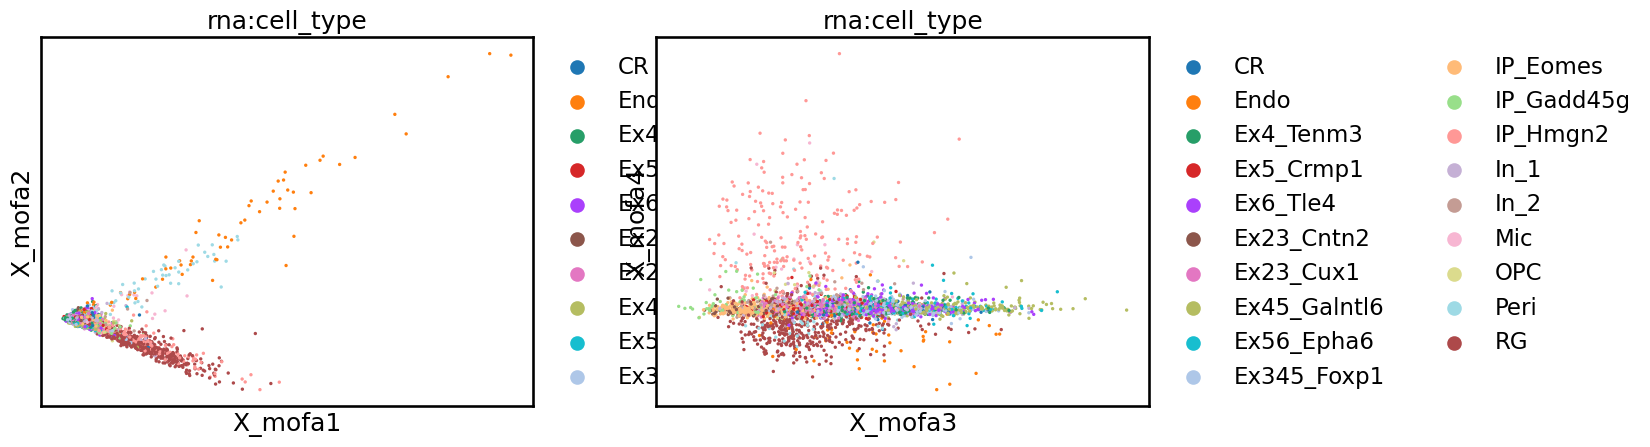

In [30]:
mu.pl.mofa(mdata, color="rna:cell_type", components=["1,2", "3,4"])
# 'rna:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['rna'].obs

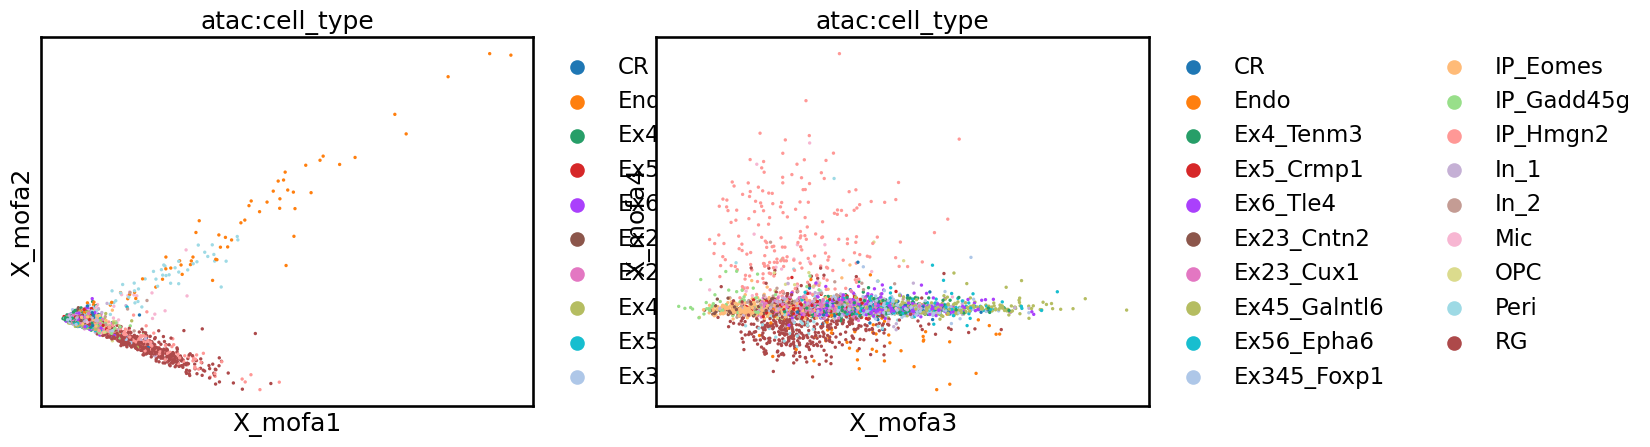

In [31]:
mu.pl.mofa(mdata, color="atac:cell_type", components=["1,2", "3,4"])
# 'atac:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['atac'].obs

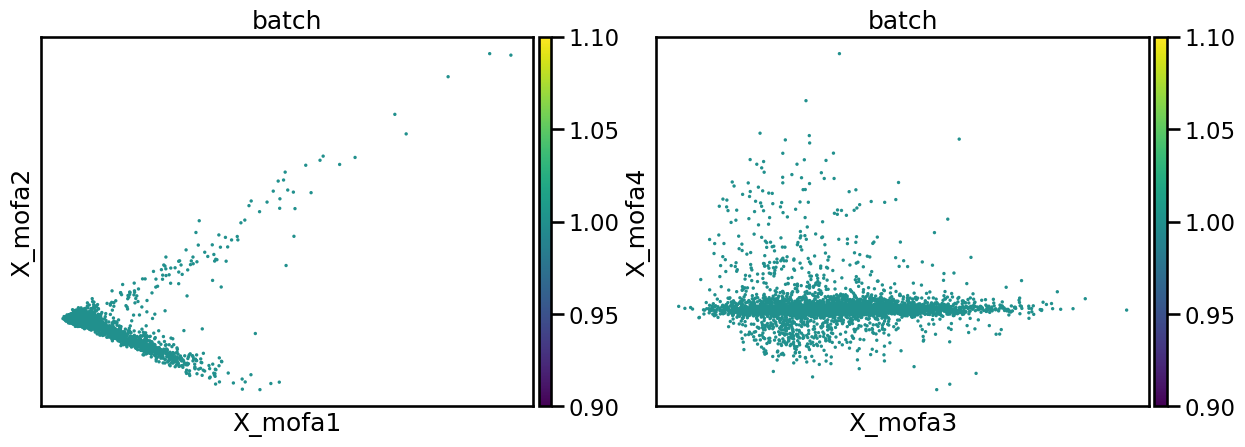

In [32]:
mu.pl.mofa(mdata, color="batch", components=["1,2", "3,4"])
# 'atac:celltype' is a column in mdata.obs
# derived from the 'celltype' column of mdata['atac'].obs

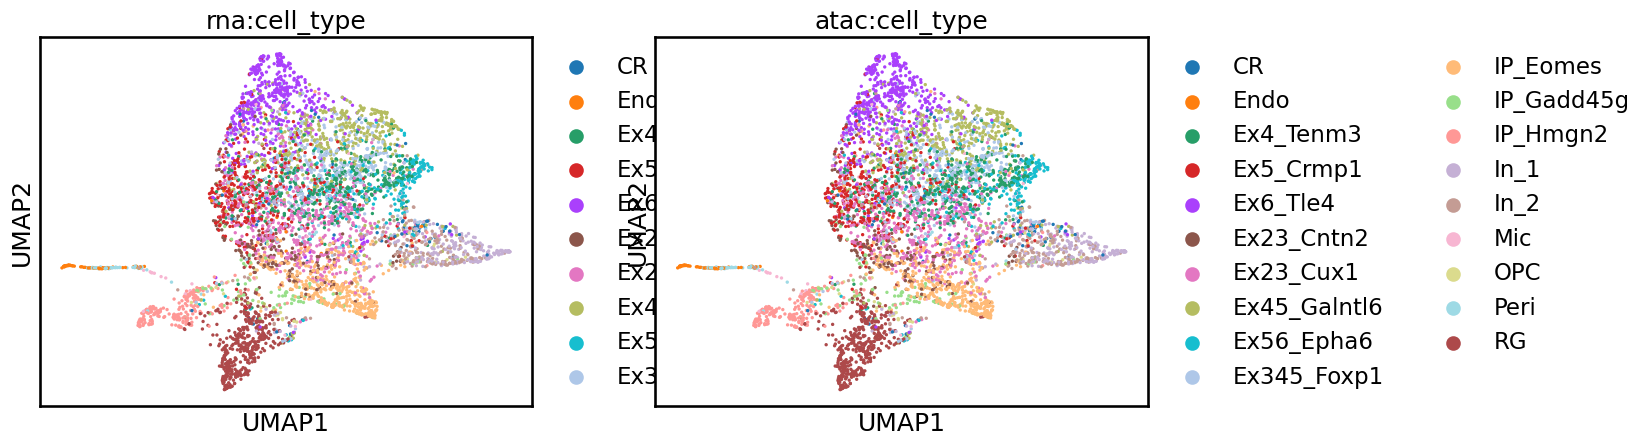

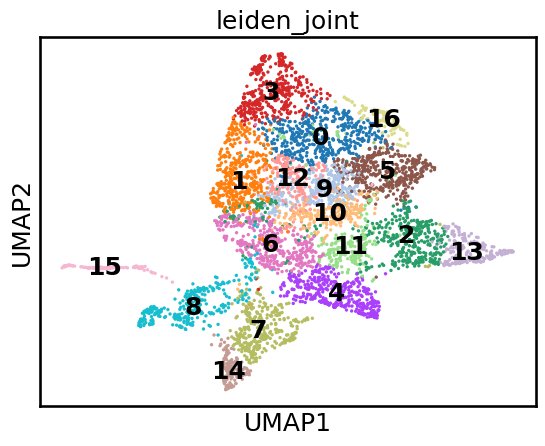

In [33]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.umap(mdata, min_dist=.2, spread=1., random_state=10)
sc.pl.umap(mdata, color=["rna:cell_type", "atac:cell_type"])
sc.tl.leiden(mdata, key_added='leiden_joint')
sc.pl.umap(mdata, color="leiden_joint", legend_loc='on data')

In [34]:
scib_anndata = sc.AnnData(mdata.obsm["X_mofa"]).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.obsp["connectivities"] = mdata.obsp["connectivities"].copy()
scib_anndata.obsm["X_mofa"] = mdata.obsm["X_mofa"].copy()

In [35]:
metrics_mofa = scib.metrics.metrics(
    scib_anndata,
    scib_anndata,
    batch_key="rna:batch",
    label_key="rna:cell_type",
    embed="X_mofa",
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_mofa

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.449069
ARI_cluster/label,0.307256
ASW_label,0.501506
ASW_label/batch,NaN
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.480922
graph_conn,0.829103
kBET,NaN


In [36]:
print(mdata.obsm["X_mofa"])
print(type(mdata.obsm["X_mofa"]))
print(mdata.obsm["X_mofa"].shape)

df = pd.DataFrame(data=mdata.obsm["X_mofa"])
df.to_csv(os.path.join("/home/xcx/results/P0/10-MOFA+/z_both.csv"), index=False)

[[-7.36705470e-01  2.29224040e-01  1.27528788e+00 ...  3.74164455e-09
   3.21224648e-12  2.59823932e-10]
 [-7.08288368e-01  9.43170678e-02  1.00105406e+00 ...  1.98235274e-09
   1.60633719e-12  1.73585608e-10]
 [-6.84741682e-01  4.15922758e-01 -9.65704328e-01 ...  3.85306489e-09
   1.72392587e-13  1.69710330e-11]
 ...
 [-6.61217954e-01 -2.66922044e-01  1.48680356e+00 ... -1.05871803e-12
  -2.86995617e-12 -1.64298295e-10]
 [ 6.38489170e-01 -1.05255246e+00  4.27284302e-01 ... -2.70632250e-09
   8.47600982e-12  3.26401836e-10]
 [ 1.31809004e-01  6.82580171e-01 -7.75860967e-01 ...  2.38740395e-08
   1.59198834e-11  8.06960560e-10]]
<class 'numpy.ndarray'>
(5081, 10)


In [43]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy()

/data1/xcx/anaconda3/envs/MOFA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


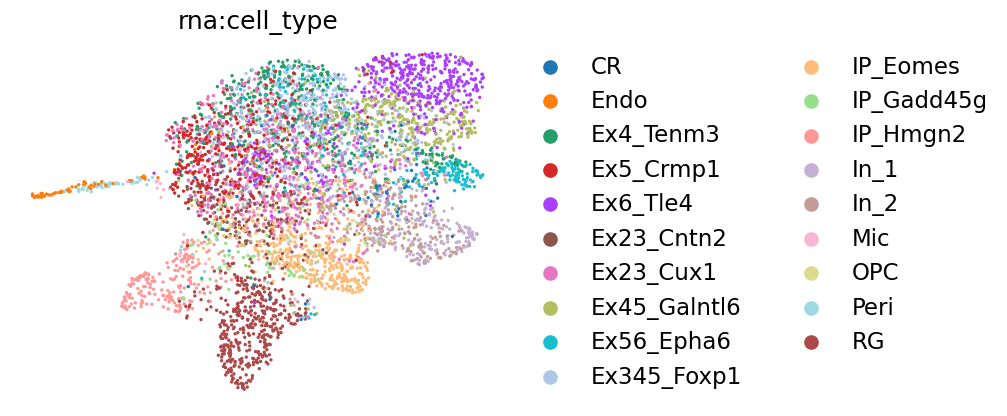

In [59]:
mu.pl.embedding(
    mdata, color=["rna:cell_type"], ncols=1, basis="umap_mofa", frameon=False
)